In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

### Preprocessing the training Data using ImageDataGenerator
#### One of the methods to prevent overfitting is to have more data. By this, our model will be exposed to more aspects of data and thus will generalize better. To get more data, either you manually collect data or generate data from the existing data by applying some transformations. The latter method is known as Data Augmentation.

 - **rescale:** rescaling factor. If None or 0, no rescaling is applied, otherwise we multiply the data by the value provided.
 - **shear_range:** This is the shear angle in the counter-clockwise direction in degrees.
 - **zoom_range:** This zooms the image.
 - **horizontal_flip:** Randomly flips the input image in the horizontal direction.

- Dataset Link: https://www.kaggle.com/datasets/tongpython/cat-and-dog

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

training_set = datagen.flow_from_directory(
        "../input/cat-and-dog/training_set/training_set/",
        target_size=(64, 64),
        batch_size=32,
        class_mode="binary"
      )


Found 8005 images belonging to 2 classes.


### Preprocessing the test Data using ImageDataGenerator

In [5]:
datagen1 = ImageDataGenerator(rescale=1./255)

test_set = datagen1.flow_from_directory(
        "../input/cat-and-dog/test_set/test_set",
        target_size=(64, 64),
        batch_size=32,
        class_mode="binary"
      )

Found 2023 images belonging to 2 classes.


# Creating the Model

### Importing useful models for CNN Layers

In [6]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense

In [7]:
from tensorflow.keras.regularizers import l2

### When to use a Sequential model

A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

A Sequential model is **not appropriate** when:
- Your model has multiple inputs or multiple outputs
- Any of your layers has multiple inputs or multiple outputs
- You need to do layer sharing
- You want non-linear topology (e.g. a residual connection, a multi-branch model)


In [8]:
cnn = tf.keras.models.Sequential()

### Step 1 - Convolution
This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. If use_bias is True, a bias vector is created and added to the outputs. Finally, if activation is not None, it is applied to the outputs as well.

When using this layer as the first layer in a model, provide the keyword argument input_shape (tuple of integers or None, does not include the sample axis), e.g. `input_shape=(64, 64, 3)` for 64x64 RGB pictures in `data_format="channels_last"`. You can use None when a dimension has variable size.

**Arguments Used:**
- **filters:** Integer, the dimensionality of the output space.
- **padding:** one of "valid" or "same". "valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input.
- **kernel_size:** An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window.
- **activation:** Activation function to use. If you don't specify anything, no activation is applied.
- **strides:** An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width.

In [9]:
cnn.add(tf.keras.layers.Conv2D(filters=32,padding="same",kernel_size=3, activation='relu', strides=2, input_shape=[64, 64, 3]))

### Step 2 - Pooling
Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. The window is shifted by strides along each dimension.

In [10]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Adding a second convolutional layer

In [11]:
cnn.add(tf.keras.layers.Conv2D(filters=32,padding='same',kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Step 3 - Flattening
**Flattens the input. Does not affect the batch size.**

**Note:** If inputs are shaped (batch,) without a feature axis, then flattening adds an extra channel dimension and output shape is (batch, 1).

In [12]:
cnn.add(tf.keras.layers.Flatten())

### Step 4 - Full Connection

In [13]:
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

### Step 5 - Output Layer

In [14]:
cnn.add(Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
             ='linear'))

### Printing out the summary of the Layers

In [15]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

## Training the CNN

### Compiling the CNN
#### Attributes:
- **optimizer:** String (name of optimizer) or optimizer instance.
- **loss:** Loss function.
- **metrics:** List of metrics to be evaluated by the model during training and testing. 

In [16]:
cnn.compile(optimizer = 'adam', loss = 'hinge', metrics = ['accuracy'])

### Training the CNN on the Training set and evaluating it on the Test set
#### Attributes:
- **x:** Input data
- **validation_data:** Data on which to evaluate the loss and any model metrics at the end of each epoch.
- **epochs:** Integer. Number of epochs to train the model.

In [17]:
r=cnn.fit(x = training_set, validation_data = test_set, epochs = 15)

Epoch 1/15
251/251 [==============================] - 79s 311ms/step - loss: 0.8888 - accuracy: 0.5760 - val_loss: 0.7972 - val_accuracy: 0.5996
Epoch 2/15
251/251 [==============================] - 41s 165ms/step - loss: 0.7314 - accuracy: 0.6593 - val_loss: 0.6699 - val_accuracy: 0.7009
Epoch 3/15
251/251 [==============================] - 41s 162ms/step - loss: 0.6634 - accuracy: 0.6889 - val_loss: 0.7089 - val_accuracy: 0.7158
Epoch 4/15
251/251 [==============================] - 41s 164ms/step - loss: 0.6290 - accuracy: 0.7072 - val_loss: 0.6057 - val_accuracy: 0.7138
Epoch 5/15
251/251 [==============================] - 41s 163ms/step - loss: 0.6044 - accuracy: 0.7176 - val_loss: 0.5710 - val_accuracy: 0.7365
Epoch 6/15
251/251 [==============================] - 41s 163ms/step - loss: 0.5617 - accuracy: 0.7399 - val_loss: 0.5727 - val_accuracy: 0.7558
Epoch 7/15
251/251 [==============================] - 41s 165ms/step - loss: 0.5537 - accuracy: 0.7410 - val_loss: 0.5787 - val_ac

## Ploting the Train loss,val loss and train acc, val acc

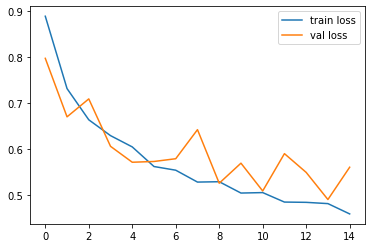

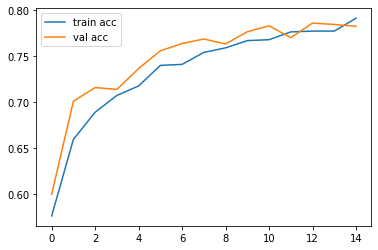

In [18]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

### Saving the trained model

In [19]:
from tensorflow.keras.models import load_model

cnn.save('./model_rcat_dog.h5')

### Taking the sample image converting the image to an array and predicting the result

In [20]:
from tensorflow.keras.preprocessing import image
test_image = image.load_img('../input/cat-and-dog/training_set/training_set/dogs/dog.1023.jpg', target_size = (64,64))
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)

In [21]:
if result[0]<0:
    print("The image classified is cat")
else:
    print("The image classified is dog")

The image classified is dog
